### AutoGlunon

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
import matplotlib.ticker as ticker

# 读取训练和测试数据
train_data = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/train.csv')
test_data = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/test.csv')

# 目标列名
label = 'target'

# 确认标签列在数据集中
assert label in train_data.columns, "Label column not found in training data"

# 训练 AutoGluon 模型
predictor = TabularPredictor(label=label, eval_metric='rmse').fit(train_data, num_stack_levels=1, num_bag_folds=5, time_limit=3600)

# 检查训练的模型列表
print(predictor.leaderboard(train_data, silent=False))

# 进行预测
predictions_test = predictor.predict(test_data.drop(columns=[label]))
predictions_train = predictor.predict(train_data.drop(columns=[label]))

##-------------------绘图------------------------------------##
# 计算 RMSE, R² 和 MAE
r2_test = r2_score(test_data[label], predictions_test)
mae_test = mean_absolute_error(test_data[label], predictions_test)
rmse_test = np.sqrt(mean_squared_error(test_data[label], predictions_test))

print(f"Test R²: {r2_test}")
print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")

# 设置字体
plt.rc('font', family='Times New Roman')

# 测试集图形
plt.figure(figsize=(6, 6))
plt.scatter(test_data[label], predictions_test, color='#FF80C0', label='Predicted vs True')

# 设置坐标轴范围和间隔，并绘制对角线
max_val_test = int(np.ceil(max(test_data[label].max(), predictions_test.max()) / 10.0)) * 10
plt.plot([0, max_val_test], [0, max_val_test], 'k--', label='Diagonal Line')
plt.xlim([0, max_val_test])
plt.ylim([0, max_val_test])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))

# 添加 RMSE, R² 和 MAE 值到图中
plt.text(70, max_val_test * 0.25, f'R²: {r2_test:.4f}', fontsize=12, color='black')
plt.text(70, max_val_test * 0.20, f'MAE: {mae_test:.4f}', fontsize=12, color='black')
plt.text(70, max_val_test * 0.15, f'RMSE: {rmse_test:.4f}', fontsize=12, color='black')

# 设置x轴和y轴刻度标签字体大小为12
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('GCMC Simulated Capacity (mg/g)', fontsize=12)
plt.ylabel('Predicted Capacity (mg/g)', fontsize=12)
#plt.legend()
plt.savefig('F:/2024-阴离子柱MOF-机器学习储氢/3-做图/AG-test-LCD.png',dpi=500)
plt.show()

# 训练集图形
r2_train = r2_score(train_data[label], predictions_train)
mae_train = mean_absolute_error(train_data[label], predictions_train)
rmse_train = np.sqrt(mean_squared_error(train_data[label], predictions_train))

print(f"Train R²: {r2_train}")
print(f"Train MAE: {mae_train}")
print(f"Train RMSE: {rmse_train}")

plt.figure(figsize=(6, 6))
plt.scatter(train_data[label], predictions_train, color='#0080FF', label='Predicted vs True')

# 设置坐标轴范围和间隔，并绘制对角线
max_val_train = int(np.ceil(max(train_data[label].max(), predictions_train.max()) / 10.0)) * 10
plt.plot([0, max_val_train], [0, max_val_train], 'k--', label='Diagonal Line')
plt.xlim([0, max_val_train])
plt.ylim([0, max_val_train])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))

# 添加 RMSE, R² 和 MAE 值到图中
plt.text(70, max_val_train * 0.25, f'R²: {r2_train:.4f}', fontsize=12, color='black')
plt.text(70, max_val_train * 0.20, f'MAE: {mae_train:.4f}', fontsize=12, color='black')
plt.text(70, max_val_train * 0.15, f'RMSE: {rmse_train:.4f}', fontsize=12, color='black')

# 设置x轴和y轴刻度标签字体大小为12
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('GCMC Simulated Capacity (mg/g)', fontsize=12)
plt.ylabel('Predicted Capacity (mg/g)', fontsize=12)
#plt.legend()
plt.savefig('F:/2024-阴离子柱MOF-机器学习储氢/3-做图/AG-train-LCD.png',dpi=500)
plt.show()

# 输出最佳模型
predictor.leaderboard()


### H2O_modle

In [ ]:
import h2o
import shap
from h2o.estimators import H2OGradientBoostingEstimator
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Start H2O
h2o.init()

# Load data with Pandas
train_df = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/train.csv')
test_df = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/test.csv')

# Upload Pandas DataFrame to H2O
train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

# Set feature and target columns
features = train.columns[:-1]  # Assuming the last column is the target
target = train.columns[-1]

# Define and train the model
model = H2OGradientBoostingEstimator()
model.train(x=features, y=target, training_frame=train)

# Predictions for both train and test sets
pred_train = model.predict(train).as_data_frame().values.flatten()
pred_test = model.predict(test).as_data_frame().values.flatten()

# Extract actual values
true_train = train_df[target].values.flatten()
true_test = test_df[target].values.flatten()

# Define the path to save the model
model_save_path = "F:/2024-阴离子柱MOF-机器学习储氢/1-计算脚本"

# Save the trained model
model_path = h2o.save_model(model=model, path=model_save_path, force=True)
print(f"Model saved to: {model_path}")

# Calculate RMSE, R², and MAE for both sets
r2_train = r2_score(true_train, pred_train)
mae_train = mean_absolute_error(true_train, pred_train)
rmse_train = np.sqrt(mean_squared_error(true_train, pred_train))

r2_test = r2_score(true_test, pred_test)
mae_test = mean_absolute_error(true_test, pred_test)
rmse_test = np.sqrt(mean_squared_error(true_test, pred_test))

print(f"Train R²: {r2_train}")
print(f"Train MAE: {mae_train}")
print(f"Train RMSE: {rmse_train}")

print(f"Test R²: {r2_test}")
print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")

# Font setting for consistency in plot text
plt.rc('font', family='Times New Roman')

# Plot function to avoid repetition
def plot_results(true_values, pred_values, title, save_path, color):
    plt.figure(figsize=(6, 6))
    plt.scatter(true_values, pred_values, color=color, label='Predicted vs True')

    # Set axis limits based on max values
    max_val = int(np.ceil(max(true_values.max(), pred_values.max()) / 10.0)) * 10
    plt.plot([0, max_val], [0, max_val], 'k--', label='Diagonal Line')
    plt.xlim([0, max_val])
    plt.ylim([0, max_val])
    
    # Set tick intervals
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))

    # Add RMSE, R², and MAE values
    plt.text(70, max_val * 0.25, f'R²: {r2_score(true_values, pred_values):.4f}', fontsize=12, color='black')
    plt.text(70, max_val * 0.20, f'MAE: {mean_absolute_error(true_values, pred_values):.4f}', fontsize=12, color='black')
    plt.text(70, max_val * 0.15, f'RMSE: {np.sqrt(mean_squared_error(true_values, pred_values)):.4f}', fontsize=12, color='black')

    # Set axis labels and save
    plt.xlabel('GCMC Simulated Capacity (mg/g)', fontsize=12)
    plt.ylabel('Predicted Capacity (mg/g)', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.title(title, fontsize=14)
    plt.savefig(save_path, dpi=500)
    plt.show()

# Plot results for test and train sets with specified colors
plot_results(true_test, pred_test, "H2O Test Set Comparison", 'F:/2024-阴离子柱MOF-机器学习储氢/3-做图/H2O-test_set_comparison-LCD.png', color='#FF80C0')
plot_results(true_train, pred_train, "H2O Train Set Comparison", 'F:/2024-阴离子柱MOF-机器学习储氢/3-做图/H2O-train_set_comparison-LCD.png', color='#0080FF')

# Shutdown H2O
h2o.shutdown(prompt=False)


### 根据训练好的模型进行预测数据

In [ ]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Start H2O
h2o.init()

# Load data with Pandas
train_df = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/train.csv')
test_df = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/test.csv')

# Upload Pandas DataFrame to H2O
train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

# Set feature and target columns
features = train.columns[:-1]  # Assuming the last column is the target
target = train.columns[-1]

# Define and train the model
model = H2OGradientBoostingEstimator()
model.train(x=features, y=target, training_frame=train)


def predict_and_export(model, data_path, output_path):
    new_data_df = pd.read_csv(data_path)
    
    # Ensure only features are used in predictions
    if target in new_data_df.columns:
        new_data_df = new_data_df.drop(columns=[target])

    new_data_h2o = h2o.H2OFrame(new_data_df)
    
    # Perform prediction
    predictions = model.predict(new_data_h2o).as_data_frame()
    
    # Add predictions to original data
    new_data_df['Predicted'] = predictions.values.flatten()
    
    # Save to Excel
    new_data_df.to_excel(output_path, index=False)
    print(f"Predictions saved to {output_path}")

# Call function for prediction on new data and export to Excel
predict_and_export(model, 'F:/2024-阴离子柱MOF-机器学习储氢/2-数据/new_data.csv', 
                   'F:/2024-阴离子柱MOF-机器学习储氢/2-数据/predictions_output.xlsx')

# Shutdown H2O
h2o.shutdown(prompt=False)


### H2O网格搜索模型

### 5折交叉验证-H2O


In [ ]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Start H2O
h2o.init()

# Load data with Pandas
train_df = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/train.csv')
test_df = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/test.csv')

# Upload Pandas DataFrame to H2O
train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

# Set feature and target columns
features = train.columns[:-1]  # Assuming the last column is the target
target = train.columns[-1]

# Define the model with 5-fold cross-validation
model = H2OGradientBoostingEstimator(nfolds=5)

# Train the model with cross-validation
model.train(x=features, y=target, training_frame=train)

# Print cross-validation metrics
print("Cross-Validation Metrics:")
model.cross_validation_metrics_summary().show()

# Predictions for both train and test sets
pred_train = model.predict(train).as_data_frame().values.flatten()
pred_test = model.predict(test).as_data_frame().values.flatten()

# Extract actual values
true_train = train_df[target].values.flatten()
true_test = test_df[target].values.flatten()

# Calculate RMSE, R², and MAE for both sets
r2_train = r2_score(true_train, pred_train)
mae_train = mean_absolute_error(true_train, pred_train)
rmse_train = np.sqrt(mean_squared_error(true_train, pred_train))

r2_test = r2_score(true_test, pred_test)
mae_test = mean_absolute_error(true_test, pred_test)
rmse_test = np.sqrt(mean_squared_error(true_test, pred_test))

print(f"Train R²: {r2_train}")
print(f"Train MAE: {mae_train}")
print(f"Train RMSE: {rmse_train}")

print(f"Test R²: {r2_test}")
print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")

# Cross-validation metrics summary
print("Cross-Validation Metrics Summary:")
print(model.cross_validation_metrics_summary())


### pycaret

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Regression
3,Original data shape,"(485, 15)"
4,Transformed data shape,"(485, 15)"
5,Transformed train set shape,"(339, 15)"
6,Transformed test set shape,"(146, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.9966,2.3721,1.5235,0.9959,0.0385,0.0235,0.0260
gbr,Gradient Boosting Regressor,1.3043,3.4513,1.8446,0.9941,0.0445,0.0307,0.0280
rf,Random Forest Regressor,1.3000,3.8338,1.9372,0.9933,0.0458,0.0299,0.0360
lightgbm,Light Gradient Boosting Machine,1.5946,6.9574,2.5524,0.9882,0.0530,0.0342,0.0360
ada,AdaBoost Regressor,2.1591,7.6034,2.7458,0.9869,0.0684,0.0523,0.0180
lr,Linear Regression,2.1809,7.7115,2.7753,0.9867,0.0732,0.0539,0.0040
br,Bayesian Ridge,2.2090,7.8231,2.7953,0.9865,0.0754,0.0554,0.0080
dt,Decision Tree Regressor,1.6932,8.4496,2.8758,0.9853,0.0654,0.0392,0.0080
knn,K Neighbors Regressor,2.2578,12.5238,3.4469,0.9788,0.0912,0.0576,0.0140
ridge,Ridge Regression,2.9051,13.8981,3.7187,0.9759,0.1064,0.0768,0.0100


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9992,2.0682,1.4381,0.9968,0.0340,0.0235
1,1.0713,2.3690,1.5392,0.9952,0.0343,0.0239
2,1.0717,3.5892,1.8945,0.9941,0.0346,0.0203
3,0.9951,2.4097,1.5523,0.9956,0.0461,0.0259
4,0.8455,1.4246,1.1936,0.9977,0.0433,0.0241
Mean,0.9966,2.3721,1.5235,0.9959,0.0385,0.0235
Std,0.0825,0.7033,0.2258,0.0013,0.0052,0.0018


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.3232,2.9328,1.7126,0.9940,0.0346,0.0274


Transformation Pipeline and Model Successfully Saved
            name      PLD  desity(g/cm^3)  VSA(m^2/cm^3)   GSA(m^2/g)  \
0  SnFSIX_4_Zn_i  6.59662        1.086920     705.179016   648.788025   
1  SnFSIX_5_Cd_i  5.33524        0.915525    1480.650024  1617.270020   
2  SnFSIX_5_Co_i  4.87179        0.945394    1356.390015  1434.729980   
3  SnFSIX_5_Cu_i  4.94672        0.939002    1365.719971  1454.439941   
4  SnFSIX_5_Fe_i  5.11139        0.930416    1336.449951  1436.400024   

   Vp(cm^3/g)  void_fraction      C/wt%     H/wt%     N/wt%      F/wt%  \
0    0.403950        0.43906  50.396904  3.172097  7.346489  14.946305   
1    0.559308        0.51206  54.943050  3.353447  5.824867  11.850592   
2    0.507598        0.47988  58.177521  3.550863  6.167774  12.548230   
3    0.514323        0.48295  57.883575  3.532922  6.136611  12.484831   
4    0.511739        0.47613  58.375961  3.562974  6.188812  12.591032   

   total degree of unsaturation  metalic percentage  \
0       

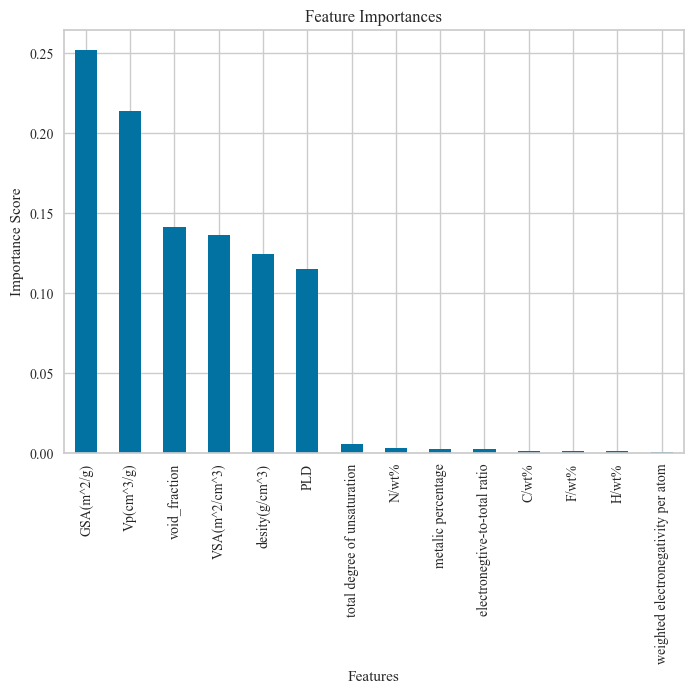

Test RMSE: 1.7126
Test R²: 0.9940


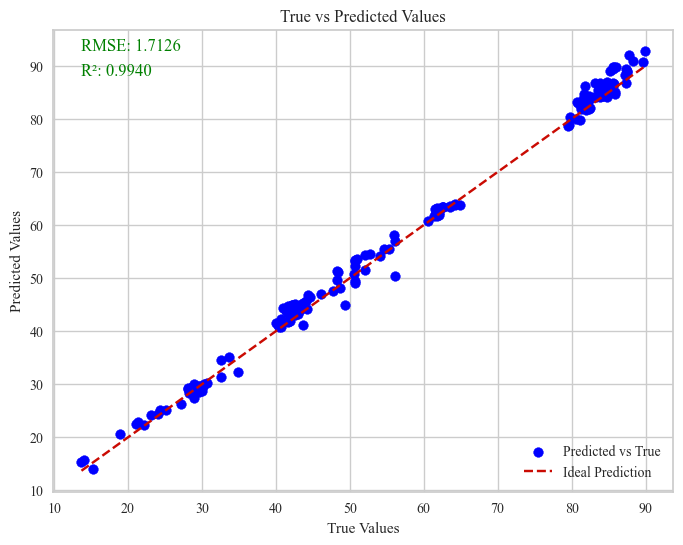

In [ ]:
from pycaret.regression import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
train = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/train-LCD.csv')
test = pd.read_csv('F:/2024-阴离子柱MOF-机器学习储氢/2-数据/test-LCD.csv')

# Set up the data with 5-fold cross-validation, using the last column as the target
target_column = train.columns[-1]  # Get the last column name
regression_setup = setup(data=train, target=target_column, session_id=42, fold=5)

# Compare different models and select the best one
best_model = compare_models()

# Train the best model using cross-validation
final_model = create_model(best_model)

# Make predictions on the test set
predictions = predict_model(final_model, data=test)

# 保存训练好的模型
save_model(final_model, 'best_trained_model')

# Print prediction results to check column names
print(predictions.head())


# 如果模型支持特征重要性，可以直接提取
if hasattr(final_model, 'feature_importances_'):
    feature_importances = pd.Series(final_model.feature_importances_, index=train.columns[:-1])
    feature_importances = feature_importances.sort_values(ascending=False)

    # 打印特征重要性
    print(feature_importances)

    # 可视化特征重要性
    feature_importances.plot(kind='bar', title='Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.show()
else:
    print("该模型不支持提取特征重要性。")



# Calculate RMSE and R²
y_test = test[target_column]  # Extract true target values from the test set
y_pred = predictions['prediction_label']  # Extract predicted values from the predictions

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print RMSE and R²
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

# Plot true vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction')

# Annotate RMSE and R² on the plot
plt.text(min(y_test), max(y_pred), f'RMSE: {rmse:.4f}', fontsize=12, color='green')
plt.text(min(y_test), max(y_pred) * 0.95, f'R²: {r2:.4f}', fontsize=12, color='green')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
